In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vs_uncert_data = surfvel_data_40kms["vs_uncert"].data

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(13.5)*np.ones((JMAX+1, IMAX+1))

dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init}
dict_params_fields_num_dims = {"xx_c_slide_init": "2D"}
dict_params_coords = {"time_ad": time_ad,
               "zeta_c": exp_sigma_level,
               "y": yModel40,
               "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field"}
dict_masks_observables = {"vs": vs_uncert_data**(-2)}

prior_alpha = 10000.0
prior_delta_z_scaler = 1.0
dict_prior_sigmas = {"xx_c_slide_init": None}
dict_prior_gammas = {"xx_c_slide_init": 1.0}
dict_prior_deltas = {"xx_c_slide_init": 0.000001}

In [4]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.copy_dir(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff.nc",
            sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")

ds_prior = xr.open_dataset(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")
ds_prior["prior_alpha"] = xr.DataArray([prior_alpha], dims=["scalar"], attrs={"type": "hyperparameter_prior"})
ds_prior["prior_delta_z_scaler"] = xr.DataArray([prior_delta_z_scaler], dims=["scalar"], attrs={"type": "hyperparameter_prior"})

# ds_prior["xx_c_slide_init"].data = ds_prior["xx_c_slide_init"].data*0.0

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
ds_prior["genarr2d_gamma_arr"] = xr.DataArray([dict_prior_gammas["xx_c_slide_init"]], dims=["genarr2d"], attrs={"type": "hyperparameter_prior"})
ds_prior["genarr2d_delta_arr"] = xr.DataArray([dict_prior_deltas["xx_c_slide_init"]], dims=["genarr2d"], attrs={"type": "hyperparameter_prior"})

DA.remove_dir(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")
ds_prior.to_netcdf(sicopolis_dir + "/src/subroutines/tapenade/ad_io/ad_input_nodiff_prior.nc")

In [5]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
ds_x_tlm_only = DA.subset_of_ds(ds_x, "type", "tlm")
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1561261.5406998424, 1561261.5407093319)

In [6]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(1561261.5406998424, 1561261.5407093319)

In [7]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_A_Cx = DA.eval_tlm_action()
ds_noise_cov_inv_A_Cx = DA.eval_noise_cov_inv_action(ds_A_Cx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_C_H_misfit_Cx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_Cx, ds_noise_cov_inv_A_Cx], ["tlmhessaction", "adjhessaction"])

(13655036392619.502, 12311006875000.965)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_Cx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_adj_action_or_tlm_action = "tlm_action")
ds_C_inv_Cx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_C_inv_Cx, ds_C_inv_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(3028.4947761548765, 3029.454237250992)

In [9]:
DA.l2_inner_product([ds_Cx, ds_Cx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"])

(78232016586.13113, 3029.454237250992)

In [10]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

dict_tlm_action_only_fields_vals = {}
for var in ds_x_tlm_only:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x_tlm_only[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_C_H_Cx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_misfit_Cx], ["tlm", "adj"]) + prior_alpha*DA.l2_inner_product([ds_x_tlm_only, ds_x_tlm_only], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x_tlm_only, ds_C_H_Cx], ["tlm", "adj"])

(13655036392619.502, 13655066687161.875, 13655066687161.879)

In [11]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.gradient_descent(5, init_alpha = 1.0, min_alpha_tol = 1.e-10)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.0078125
---------------------------------------------------------------------------------------------------------------
iter 1, fc = 49524.33164391702, fc_data = 3959.4721521346028, fc_reg = 45564.85949178242
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.125
---------------------------------------------------------------------------------------------------------------
iter 2, fc = 49384.4087185181, fc_data = 3832.572490265227, fc_reg = 45551.83622825287
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.0156

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB 1.13 1.13 1.13 1.13 ... 1.13 1.13 1.13
Attributes:
    history:  2025-02-14 13:44:56 -06:00 - Data produced

In [12]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.inexact_gn_hessian_cg(MAX_ITERS=5, init_alpha_gd = 1.e-6)

---------------------------------------------------------------------------------------------------------------
Initial fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 1232855896.8969603, norm_r_hat: 90977916.15389395
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 18690.41303029681, fc_data = 18690.41301909647, fc_reg = 1.1200338574189351e-05
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 146550809.69789538, norm_r_hat: 33601072.59182382
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  179.99999914622634
Step size alpha = 1.0
------------

<xarray.Dataset> Size: 26kB
Dimensions:          (y: 73, x: 43)
Coordinates:
  * x                (x) float64 344B -7.2e+05 -6.8e+05 ... 9.2e+05 9.6e+05
  * y                (y) float64 584B -3.45e+06 -3.41e+06 ... -6.1e+05 -5.7e+05
Data variables:
    xx_c_slide_init  (y, x) float64 25kB -0.5769 -0.5778 -0.57 ... -3.747 -3.766
Attributes:
    history:  2025-02-14 13:45:23 -06:00 - Data produced

In [13]:
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared = DA.forward_uq_propagation(5, 5)
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared

(6.989640011116947e+24, -6.45277231519809e+22, 1.0092319093757833)

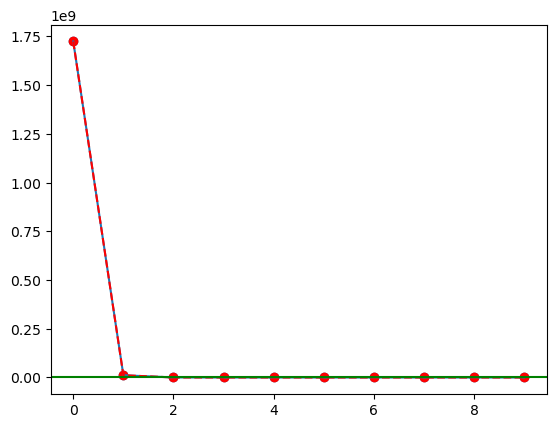

In [14]:
U_misfit, Lambda_misfit = DA.revd(5, 5, mode = "misfit_prior_precond")
U_full, Lambda_full = DA.revd(5, 5, mode = "full_prior_precond")

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.scatter(np.arange(Lambda_full.shape[0]), np.sort(Lambda_full)[::-1], color = "red")
plt.plot(np.sort(Lambda_full)[::-1], "r--")

plt.axhline(1, color = "green")

In [15]:
DA = optim_new.DataAssimilation(sicopolis_dir, simulation,
                                dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                                dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                                dict_og_params_fields_vals, dict_params_fields_num_dims, 
                                dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                                prior_alpha, prior_delta_z_scaler, dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
                                None, True, "0002.nc", "/scratch2/shreyas/temp_dir")

DA.l_bfgs(5, 3)

---------------------------------------------------------------------------------------------------------------
Initial fc = 124351.25048805274, fc_data = 124351.25048805274, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Step size alpha = 0.0078125
---------------------------------------------------------------------------------------------------------------
Iter 1, fc = 49524.33164391702, fc_data = 3959.4721521346028, fc_reg = 45564.85949178242
---------------------------------------------------------------------------------------------------------------
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Iter 2, fc = 49512.81244132098, fc_data = 3948.8047659389154, fc_reg = 45564.00767538207
---------------------------------------------------------------------------------------------------------------
Minimum tolerable step s

FileNotFoundError: [Errno 2] No such file or directory: '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS/src/subroutines/tapenade/ad_io/ad_output_adj.nc'